In [1]:
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn

import geopy.distance as distance

In [28]:
radar_id = 32
site_latlon_dict = {2:[-37.8553, 144.7554], 71:[-33.7008, 151.2094], 66:[-27.7178, 153.24], 31:[-34.94,117.82], 32:[-33.83,121.89], 95:[-35.99,142.01]}
rrate_multiplier = 4 #convert mm in 15min to mm/hr
min_rrate = 10
max_rrate = 150
search_string = '*'
data_root = '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary'

site_latlon = site_latlon_dict[radar_id]

In [29]:
#list files
data_path = f'{data_root}/{radar_id:02}'
data_ffn_list = sorted(glob(data_path + f'/{search_string}.npz'))

In [30]:
gauge_rrate = []
rf3_rrate = []
dp_rrate = []
gauge_lat = []
gauge_lon = []
gauge_dt64 = np.array([], dtype='datetime64')

print(data_ffn_list)

for data_ffn in data_ffn_list:
    data = np.load(data_ffn)
    gauge_rrate = np.append(gauge_rrate, data['gauge_rain'])
    rf3_rrate= np.append(rf3_rrate, data['rf3_acrain'])
    dp_rrate = np.append(dp_rrate, data['dp_acrain'])
    gauge_dt64 = np.append(gauge_dt64, data['gauge_dt64'])
    gauge_lat = np.append(gauge_lat, data['gauge_lat'])
    gauge_lon = np.append(gauge_lon, data['gauge_lon'])

#convert from mm in 15min to mm/hr
gauge_rrate = gauge_rrate*rrate_multiplier
rf3_rrate = rf3_rrate*rrate_multiplier
dp_rrate = dp_rrate*rrate_multiplier


['/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200418.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200524.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200529.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200628.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200708.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200717.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200803.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20200811.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20201003.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20201102.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20201107.npz', '/g/data/kl02/jss548/PST/dprain/dprain-verify-summary/32/32_20201127.npz']


In [31]:
# #remove outliers
outlier_mask = np.logical_or(rf3_rrate>max_rrate, dp_rrate>max_rrate)
print('number of outliers:', np.sum(outlier_mask))

filt_rf3_rrate = rf3_rrate[~outlier_mask]
filt_dp_rrate = dp_rrate[~outlier_mask]
filt_gauge_rrate = gauge_rrate[~outlier_mask]
filt_gauge_dt64 = gauge_dt64[~outlier_mask]
filt_gauge_lat = gauge_lat[~outlier_mask]
filt_gauge_lon = gauge_lon[~outlier_mask]


rate_mask = np.logical_and(filt_gauge_rrate >= min_rrate, filt_gauge_rrate <= max_rrate)
zero_mask = np.logical_and(filt_rf3_rrate>=0, filt_dp_rrate>=0)
filter_idx = np.where(np.logical_and(rate_mask, zero_mask))[0]

filt_rf3_rrate = filt_rf3_rrate[filter_idx]
filt_dp_rrate = filt_dp_rrate[filter_idx]
filt_gauge_rrate = filt_gauge_rrate[filter_idx]
filt_gauge_dt64 = filt_gauge_dt64[filter_idx]
filt_gauge_lat = gauge_lat[filter_idx]
filt_gauge_lon = gauge_lon[filter_idx]


rf3_rrate_bias = filt_rf3_rrate - filt_gauge_rrate
dp_rrate_bias   = filt_dp_rrate - filt_gauge_rrate

print('RF3 bias', np.nanmean(rf3_rrate_bias), 'RF3 std', np.nanstd(rf3_rrate_bias), 'samples:',len(rf3_rrate_bias))
print('DP bias', np.nanmean(dp_rrate_bias), 'DP std', np.nanstd(dp_rrate_bias), 'samples:',len(dp_rrate_bias))

number of outliers: 0
RF3 bias -4.223249204456806 RF3 std 8.948280330187655 samples: 24
DP bias 0.5590239974359671 DP std 10.514385900663354 samples: 24


In [32]:
#range analysis
rng1_limits = [0,50]
rng2_limits = [50,100]

gauge_dist = []
for i in range(len(filt_gauge_rrate)):
    gauge_dist.append(distance.geodesic(site_latlon, [filt_gauge_lat[i], filt_gauge_lon[i]]).km)
    
gauge_dist = np.array(gauge_dist)    

rng1_mask = np.logical_and(gauge_dist>rng1_limits[0], gauge_dist<rng1_limits[1])
rng2_mask = np.logical_and(gauge_dist>rng2_limits[0], gauge_dist<rng2_limits[1])

rng1_rf3_rrate_bias = filt_rf3_rrate[rng1_mask] - filt_gauge_rrate[rng1_mask]
rng1_dp_rrate_bias  = filt_dp_rrate[rng1_mask] - filt_gauge_rrate[rng1_mask]
rng1_gauge_count = len(np.unique(gauge_dist[rng1_mask]))

rng2_rf3_rrate_bias = filt_rf3_rrate[rng2_mask] - filt_gauge_rrate[rng2_mask]
rng2_dp_rrate_bias  = filt_dp_rrate[rng2_mask] - filt_gauge_rrate[rng2_mask]
rng2_gauge_count = len(np.unique(gauge_dist[rng2_mask]))

print('rng 1 RF3 bias', np.nanmean(rng1_rf3_rrate_bias), 'RF3 std', np.nanstd(rng1_rf3_rrate_bias))
print('rng 1 DP bias', np.nanmean(rng1_dp_rrate_bias), 'DP std', np.nanstd(rng1_dp_rrate_bias))
print('rng 1 n gauges', rng1_gauge_count)

print('rng 2 RF3 bias', np.nanmean(rng2_rf3_rrate_bias), 'RF3 std', np.nanstd(rng2_rf3_rrate_bias))
print('rng 2 DP bias', np.nanmean(rng2_dp_rrate_bias), 'DP std', np.nanstd(rng2_dp_rrate_bias))
print('rng 2 n gauges', rng2_gauge_count)


rng 1 RF3 bias -5.629315200779173 RF3 std 9.694023917752393
rng 1 DP bias 0.09360393053955501 DP std 11.923217743203969
rng 1 n gauges 4
rng 2 RF3 bias -0.005051215489705403 RF3 std 3.8262678009332536
rng 2 DP bias 1.9552841981252034 DP std 3.6222216045782156
rng 2 n gauges 3


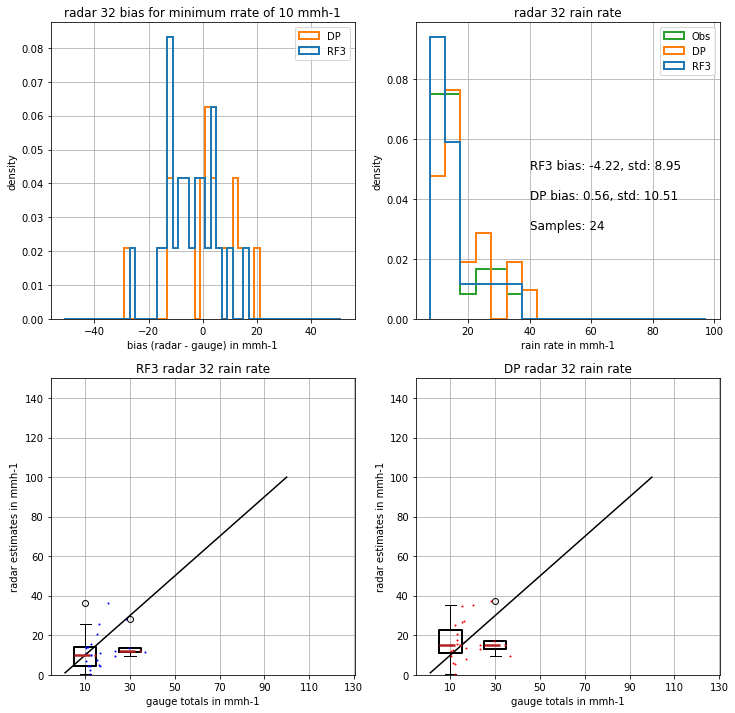

In [33]:
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')

plt.figure(figsize=[12,12])

plt.subplot(221)
plt.hist([rf3_rrate_bias, dp_rrate_bias], np.arange(-51,53,2), label=['RF3', 'DP'], histtype='step', linewidth=2, density=True)
plt.legend(loc='upper right')
plt.xlabel('bias (radar - gauge) in mmh-1')
plt.ylabel('density')
plt.title(f'radar {radar_id:02} bias for minimum rrate of {min_rrate} mmh-1')
plt.grid()

plt.subplot(222)
plt.hist([filt_rf3_rrate, filt_dp_rrate, filt_gauge_rrate], np.arange(7.5,102.5,5), label=['RF3', 'DP', 'Obs'], histtype='step', linewidth=2, density=True)
plt.legend(loc='upper right')
plt.xlabel('rain rate in mmh-1')
plt.ylabel('density')
plt.title(f'radar {radar_id:02} rain rate')
plt.grid()
plt.text(40, 0.05, f'RF3 bias: {np.nanmean(rf3_rrate_bias):.2f}, std: {np.nanstd(rf3_rrate_bias):.2f}', fontsize=12)
plt.text(40, 0.04, f'DP bias: {np.nanmean(dp_rrate_bias):.2f}, std: {np.nanstd(dp_rrate_bias):.2f}', fontsize=12)
plt.text(40, 0.03, f'Samples: {len(filt_gauge_rrate)}', fontsize=12)

plt.subplot(223)
width = 20
steps = np.arange(10,130+width,20)
for step in steps:
    step_filter = np.logical_and(filt_gauge_rrate>(step-(width/2)), filt_gauge_rrate<=(step+(width/2)))
    gauge_subset = filt_gauge_rrate[step_filter]
    radar_subset = filt_rf3_rrate[step_filter]
    plt.boxplot(radar_subset, positions=[step], widths=[width/2], boxprops=boxprops, medianprops=medianprops)
plt.plot(filt_gauge_rrate, filt_rf3_rrate,'bo', ms=1)
plt.plot([1,100],[1,100],'k-')
plt.xlabel('gauge totals in mmh-1')
plt.ylabel('radar estimates in mmh-1')
plt.title(f'RF3 radar {radar_id:02} rain rate')
#plt.xlim([-1,8])
plt.ylim([0,150])
plt.grid()

plt.subplot(224)
width = 20
steps = np.arange(10,130+width,20)
for step in steps:
    step_filter = np.logical_and(filt_gauge_rrate>(step-(width/2)), filt_gauge_rrate<=(step+(width/2)))
    gauge_subset = filt_gauge_rrate[step_filter]
    radar_subset = filt_dp_rrate[step_filter]
    plt.boxplot(radar_subset, positions=[step], widths=[width/2], boxprops=boxprops, medianprops=medianprops)
plt.plot(filt_gauge_rrate, filt_dp_rrate,'ro', ms=1)
plt.plot([1,100],[1,100],'k-')
plt.xlabel('gauge totals in mmh-1')
plt.ylabel('radar estimates in mmh-1')
plt.title(f'DP radar {radar_id:02} rain rate')
#plt.xlim([-1,8])
plt.ylim([0,150])
plt.grid()

plt.savefig(f'{radar_id:02}_dp_rrate_verification.png',dpi=100)

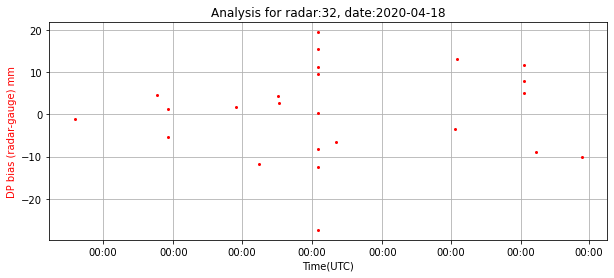

In [34]:
plt.figure(figsize=[10,4])
ax1 = plt.subplot()
time_fmt = mdates.DateFormatter('%H:%M')

ax1.set_title(f'Analysis for radar:{radar_id}, date:{np.datetime_as_string(filt_gauge_dt64[0], unit="D")}')
plt.plot(filt_gauge_dt64, dp_rrate_bias,'ro', ms=2)
ax1.set_xlabel('Time(UTC)')
ax1.set_ylabel("DP bias (radar-gauge) mm", color='r')
ax1.xaxis.set_major_formatter(time_fmt)
ax1.grid()


# plt.plot([1,100],[1,100],'k-')
# plt.xlabel('gauge totals in mmh-1')
# plt.ylabel('radar estimates in mmh-1')
# plt.title(f'DP radar {radar_id:02} rain rate')
# plt.xlim([0,100])
# plt.ylim([0,100])